In [1]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from sklearn.decomposition import PCA, FastICA
import pandas as pd

In [2]:
folderPath = os.path.join(os.getcwd(), 'SSVEP_BCI_Dataset')

In [3]:
matFiles = [f for f in os.listdir(folderPath) if f.endswith('.mat')]
matData = scipy.io.loadmat(os.path.join(folderPath,matFiles[1]))
# for matFile in matFiles:
#     matData = scipy.io.loadmat(os.path.join(folderPath,matFile))
    # print(os.path.join(folderPath,matFile),'->',matData['data'].shape)

In [4]:
data = matData['data']

In [5]:
channelInd = ['POz', 'PO3', 'PO4', 'PO5', 'PO6', 'Oz', 'O1', 'O2']

In [6]:
timeRange = np.arange(0,2.84,1/250)
len(timeRange)

710

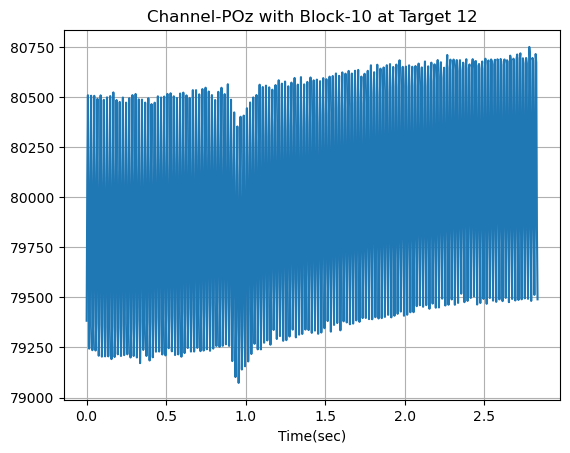

In [7]:
# “Channel index”, “Time points”, “Electrode index”（1:dry, 2:wet）, “Block index” and “Target index”
chnInd = 0
blckInd = 9
trgtInd = 11
plt.plot(timeRange,data[chnInd,:,0,blckInd,trgtInd])
plt.grid()
plt.xlabel('Time(sec)')
plt.title(f'Channel-{channelInd[chnInd]} with Block-{blckInd+1} at Target {trgtInd+1}')
plt.show()

In [8]:
# count = 1
# plt.figure(figsize=(25, 200))
# for blckInd in range(10):
#     for trgtInd in range(12):
#         plt.subplot(120,2,count)
#         count+=1
#         plt.plot(timeRange,data[chnInd,:,0,blckInd,trgtInd])
#         plt.grid()
#         # plt.xlabel('Time(sec)')
#         plt.title(f'Channel-{channelInd[chnInd]} with Block-{blckInd+1} at Target {trgtInd+1}')
#         plt.xticks(fontsize=6)  # Make x-axis ticks smaller
#         plt.yticks(fontsize=6)  # Make y-axis ticks smaller
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.5, wspace=0.3)
# plt.show()        

# FFT Analysis

In [10]:
eegData = data[0,:,0,0,0]

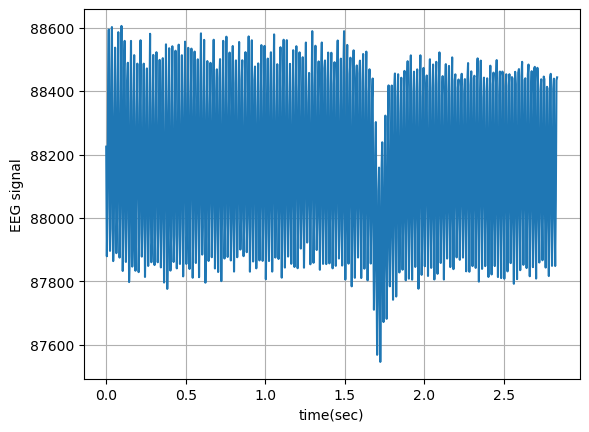

In [11]:
plt.plot(timeRange,eegData)
plt.xlabel('time(sec)')
plt.ylabel('EEG signal')
plt.grid()
plt.show()

## Data segmentation
The data length of 2.84 seconds (i.e. 2.84×250 = 710 time points) include 0.5 s before stimulus onset, 2 s for stimulation, 0.14 s visual latency, and 0.2 s after stimulus offset. 

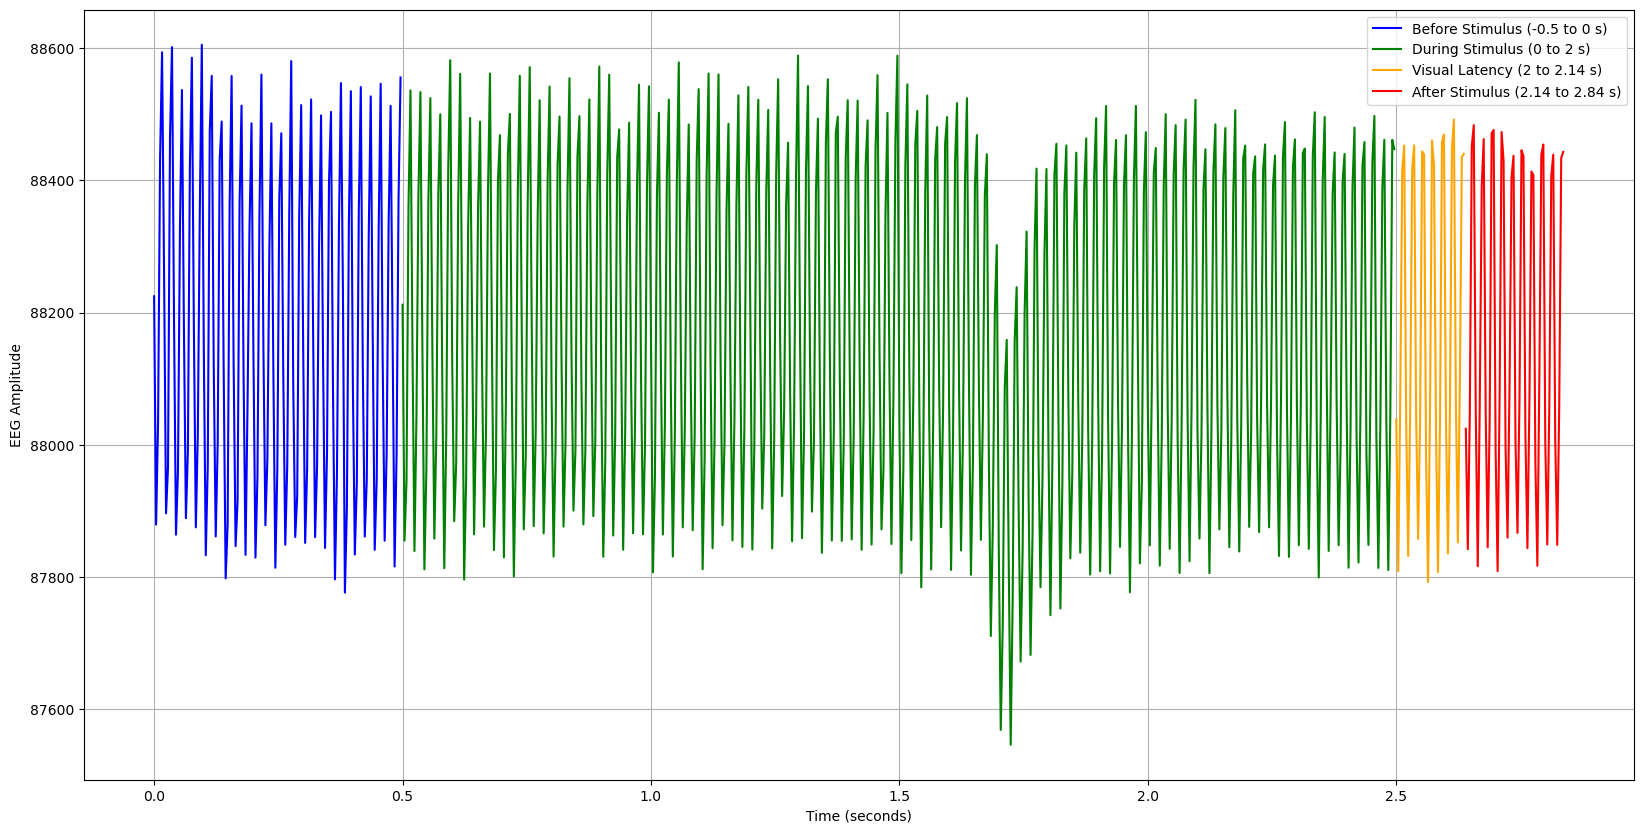

In [13]:
# Define the time sections based on the description
plt.figure(figsize=(20,10))
beforeStimulus = slice(0, 125)  # First 125 points (-0.5 s to 0 s)
duringStimulus = slice(125, 625)  # Next 500 points (0 s to 2 s)
visualLatency = slice(625, 660)  # Next 35 points (2 s to 2.14 s)
afterStimulus = slice(660, 710)  # Last 50 points (2.14 s to 2.84 s)
# Plot each time section with a different color and label
plt.plot(timeRange[beforeStimulus], eegData[beforeStimulus], color='blue', label='Before Stimulus (-0.5 to 0 s)')
plt.plot(timeRange[duringStimulus], eegData[duringStimulus], color='green', label='During Stimulus (0 to 2 s)')
plt.plot(timeRange[visualLatency], eegData[visualLatency], color='orange', label='Visual Latency (2 to 2.14 s)')
plt.plot(timeRange[afterStimulus], eegData[afterStimulus], color='red', label='After Stimulus (2.14 to 2.84 s)')
plt.xlabel('Time (seconds)')
plt.ylabel('EEG Amplitude')
plt.grid()
plt.legend()
plt.show()

In [14]:
def computeFFT(eeg_data, sampling_rate=250):
    # Length of the signal
    N = len(eeg_data)

    # Compute the FFT
    fft_result = np.fft.fft(eeg_data)

    # Compute the corresponding frequencies
    freqs = np.fft.fftfreq(N, 1/sampling_rate)

    # Get the magnitude of the FFT (only the positive half of the spectrum)
    fft_magnitude = np.abs(fft_result)[:N//2]
    freqs = freqs[:N//2]
    return freqs, fft_magnitude

In [15]:
Freq,Mag = computeFFT(eegData)

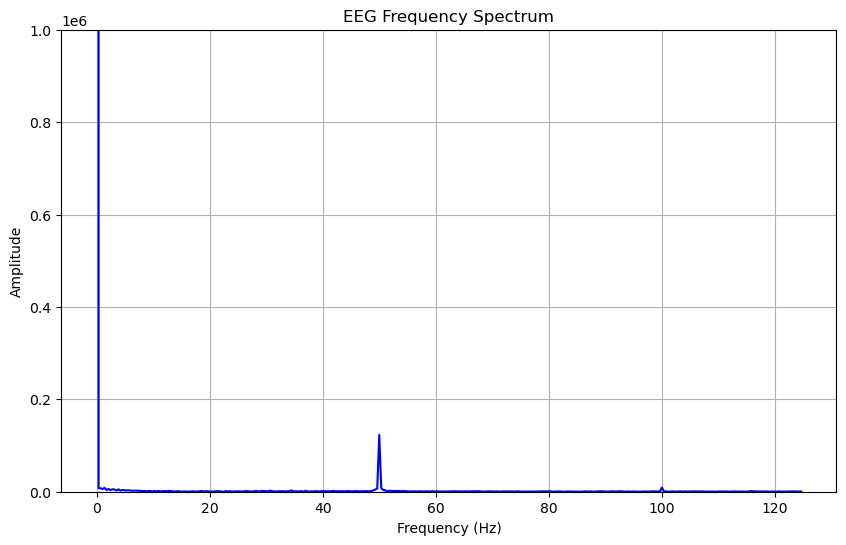

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(Freq, Mag, color='blue')
plt.title('EEG Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.ylim(-1,1000000)
plt.show()

In [17]:
# count = 1
# plt.figure(figsize=(25, 200))
# for blckInd in range(10):
#     for trgtInd in range(12):
#         plt.subplot(120,2,count)
#         count+=1
#         Freq,Mag = computeFFT(data[chnInd,:,0,blckInd,trgtInd])
#         plt.plot(Freq,Mag)
#         plt.grid()
#         # plt.xlabel('Time(sec)')
#         plt.title(f'Channel-{channelInd[chnInd]} with Block-{blckInd+1} at Target {trgtInd+1}')
#         plt.xticks(fontsize=6)  # Make x-axis ticks smaller
#         plt.yticks(fontsize=6)  # Make y-axis ticks smaller
#         # plt.grid(True)
#         plt.ylim(-1,100000)
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.5, wspace=0.3)
# plt.show()  

In [18]:
fs = 250.0  # Sample frequency (Hz)
f0 = 50.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor
# Design notch filter
b, a = signal.iirnotch(f0, Q, fs)

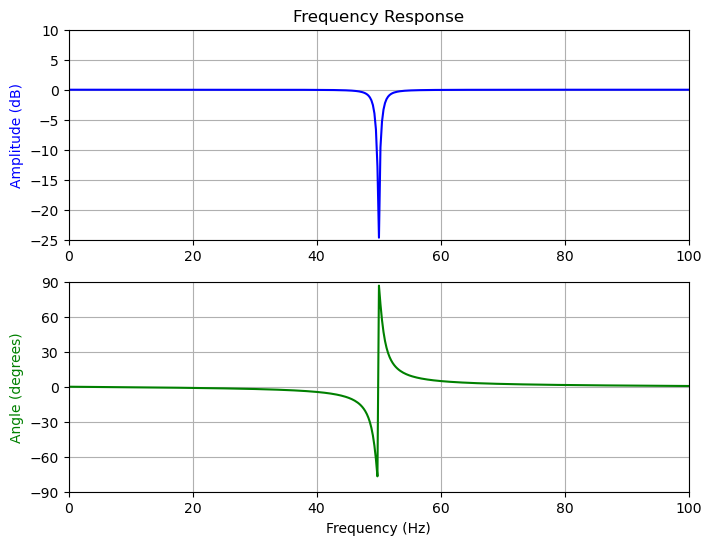

In [19]:
# Frequency response
freq, h = signal.freqz(b, a, fs=fs)
# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 100])
ax[0].set_ylim([-25, 10])
ax[0].grid(True)
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 100])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([-90, 90])
ax[1].grid(True)
plt.show()

In [20]:
def applyIIRNotchFilter(eegData, samplingRate=250, freqsToRemove=[50, 100], qualityFactor=30):
    filtered_data = eegData.copy()
    
    # Apply a notch filter for each frequency to remove
    for freq in freqsToRemove:
        # Design the notch filter
        b, a = signal.iirnotch(w0=freq, Q=qualityFactor, fs=samplingRate)
        
        # Apply the notch filter to the data
        filtered_data = signal.filtfilt(b, a, filtered_data)

    return filtered_data

In [21]:
eegDataFilt = applyIIRNotchFilter(eegData)

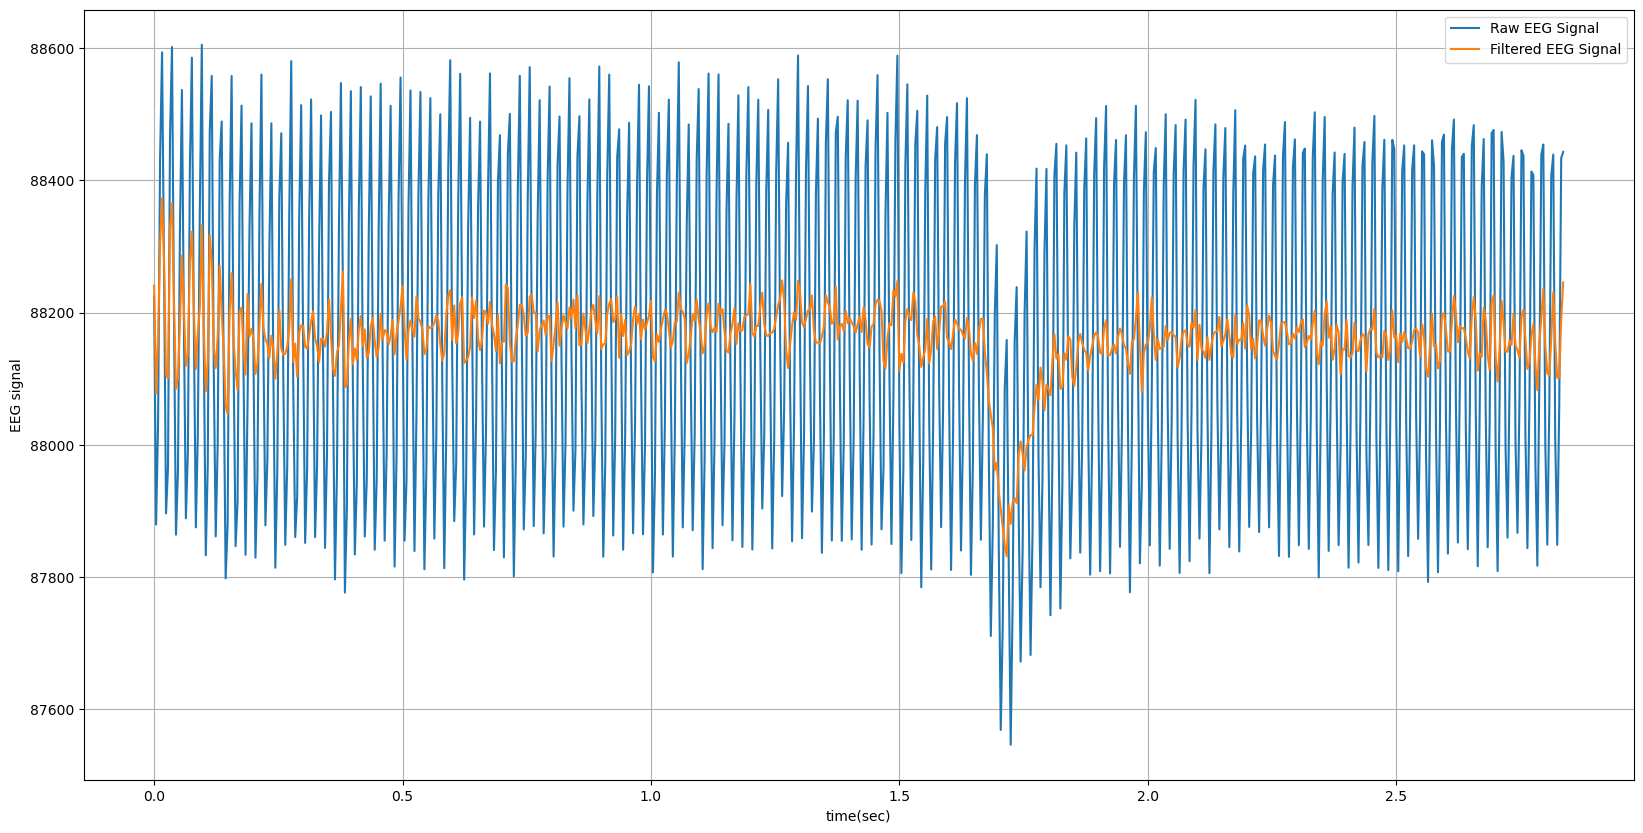

In [22]:
plt.figure(figsize=(20,10))
plt.plot(timeRange,eegData,label='Raw EEG Signal')
plt.plot(timeRange,eegDataFilt,label='Filtered EEG Signal')
plt.xlabel('time(sec)')
plt.ylabel('EEG signal')
plt.grid()
plt.legend()
plt.show()

In [23]:
FreqF,MagF = computeFFT(eegDataFilt)
Freq,Mag = computeFFT(eegData)

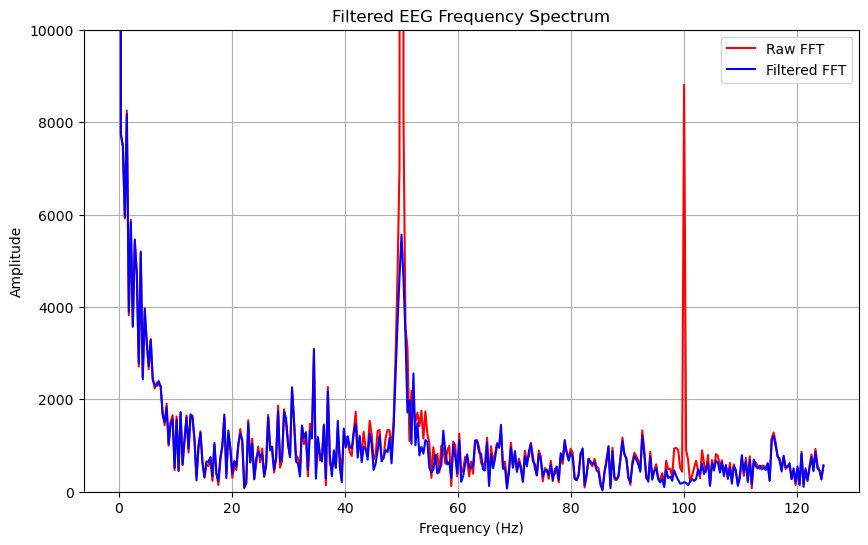

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(Freq, Mag, color='red',label='Raw FFT')
plt.plot(FreqF, MagF, color='blue',label='Filtered FFT')
plt.title('Filtered EEG Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.ylim(-1,10000)
plt.show()

In [25]:
# count = 1
# plt.figure(figsize=(25, 200))
# for blckInd in range(10):
#     for trgtInd in range(12):
#         plt.subplot(120,2,count)
#         count+=1
#         temp = applyIIRNotchFilter(data[chnInd,:,0,blckInd,trgtInd])
#         Freq,Mag = computeFFT(temp)
#         plt.plot(Freq,Mag)
#         plt.grid()
#         # plt.xlabel('Time(sec)')
#         plt.title(f'Channel-{channelInd[chnInd]} with Block-{blckInd+1} at Target {trgtInd+1}')
#         plt.xticks(fontsize=6)  # Make x-axis ticks smaller
#         plt.yticks(fontsize=6)  # Make y-axis ticks smaller
#         # plt.grid(True)
#         plt.ylim(-1,10000)
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.5, wspace=0.3)
# plt.show()  

In [26]:
# notchFreqs = 50
# numTaps = 101
# fs = 250
# nyquist = fs / 2

In [27]:
# b = signal.firwin(numTaps, notchFreqs, nyq=nyquist, pass_zero=False)

In [28]:
# filtered_signal = signal.lfilter(b, 1.0, eegData)

In [29]:
# plt.figure(figsize=(20,10))
# # plt.plot(timeRange,eegData,label='Raw EEG Signal')
# plt.plot(timeRange,filtered_signal,label='Filtered EEG Signal')
# plt.xlabel('time(sec)')
# plt.ylabel('EEG signal')
# plt.grid()
# plt.legend()
# plt.show()

In [30]:
# Freq,Mag = computeFFT(filtered_signal)

In [31]:
# plt.figure(figsize=(10, 6))
# plt.plot(Freq, Mag, color='blue')
# plt.title('EEG Frequency Spectrum')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.grid(True)
# plt.ylim(-1,100000)
# plt.show()

In [32]:
# b = signal.firwin(numTaps, [(notchFreqs-2)/nyquist,(notchFreqs+2)/nyquist], pass_zero=True)

In [33]:
# filtered_signal = signal.lfilter(b, 1.0, eegData)

In [34]:
# plt.figure(figsize=(20,10))
# # plt.plot(timeRange,eegData,label='Raw EEG Signal')
# plt.plot(timeRange,filtered_signal,label='Filtered EEG Signal')
# plt.xlabel('time(sec)')
# plt.ylabel('EEG signal')
# plt.grid()
# plt.legend()
# plt.show()

In [35]:
# Freq,Mag = computeFFT(filtered_signal)

In [36]:
# plt.figure(figsize=(10, 6))
# plt.plot(Freq, Mag, color='blue')
# plt.title('EEG Frequency Spectrum')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.grid(True)
# plt.ylim(-1,1000000)
# plt.show()

In [37]:
name = ['Time']+channelInd

In [38]:
# “Channel index”, “Time points”, “Electrode index”（1:dry, 2:wet）, “Block index” and “Target index”
electrodeIndex = 0
blockIndex = 0
targetIndex = 0
dataMat = [timeRange]
numbChannelIndex = 8

In [39]:
for chnInd in range(numbChannelIndex):
    dataMat.append(data[chnInd,:,electrodeIndex,blockIndex,targetIndex])

In [40]:
df = pd.DataFrame(dataMat)
df = df.transpose()
df.columns = name
df = df.set_index('Time')
df.head()

,POz,PO3,PO4,PO5,PO6,Oz,O1,O2
Time,,,,,,,,
0.000,88224.744095,90680.932443,87279.175954,98507.574112,114489.606886,85715.045674,79785.172926,81285.868960
0.004,87879.364960,90322.276373,86930.175837,98420.581127,114469.132690,85706.820232,79759.066091,81247.870996
0.008,88034.620168,90446.462658,87024.410786,98537.436040,114569.849644,85764.219508,79817.448844,81335.087498
0.012,88431.721236,90843.608430,87354.277811,98645.618477,114635.966100,85815.270890,79893.310660,81439.201918
0.016,88593.771374,90963.816104,87556.426976,98557.373795,114600.471532,85784.023153,79843.287459,81432.004656


In [41]:
df2 = df.copy()
for ii in df2.columns:
    df2[ii] = applyIIRNotchFilter(df2[ii])
    # print(ii)
# applyIIRNotchFilter
df2.head()

,POz,PO3,PO4,PO5,PO6,Oz,O1,O2
Time,,,,,,,,
0.000,88240.444622,90687.739840,87263.024726,98530.419859,114503.942843,85733.319648,79804.991755,81304.845298
0.004,88077.565496,90513.475832,87092.581823,98464.905727,114489.883798,85724.646312,79781.854898,81290.879055
0.008,88159.382868,90575.409890,87153.295745,98563.116370,114597.794392,85778.006869,79834.148400,81376.592563
0.012,88302.729404,90722.349139,87266.819304,98591.264339,114594.380524,85779.139997,79852.977954,81378.429466
0.016,88372.980359,90747.921150,87361.793142,98515.201214,114576.217482,85767.987183,79821.952092,81384.347176


In [42]:
NChannels = len(channelInd)

In [43]:
pca = PCA(n_components=NChannels)
pca_data = pca.fit_transform(df2)
pca_df = pd.DataFrame(pca_data, columns=channelInd)
pca_df

,POz,PO3,PO4,PO5,PO6,Oz,O1,O2
0,-109.947758,160.570064,-70.401929,22.311514,-6.352738,8.369567,7.912764,-11.103703
1,115.572321,73.851665,100.134045,70.616219,20.594193,29.494351,-5.925303,-1.908201
2,-96.785674,59.568235,108.347508,57.663762,56.321402,-0.783067,-7.485441,24.627266
3,-257.597558,132.350378,-40.514521,26.601808,15.083513,-9.320445,-15.039064,33.412778
4,-281.556360,136.696153,-131.099465,-58.764096,-38.927716,38.720994,8.100666,33.040233
...,...,...,...,...,...,...,...,...
705,49.606949,39.202412,-33.019569,-9.945360,46.024045,-8.225241,-2.923243,-11.729944
706,74.371473,-63.039157,43.800078,68.448291,31.356415,-9.898885,-11.683082,-2.060660
707,103.241250,-70.555795,37.597392,35.538201,51.061222,-6.241030,-5.304416,4.084937
708,-6.927086,0.406955,-54.080286,-1.242146,16.999464,5.249215,2.413379,-4.048072


In [44]:
ica = FastICA(n_components=NChannels)
ica_data = ica.fit_transform(pca_df)
ica_df = pd.DataFrame(ica_data, columns=channelInd)
ica_df.head()

,POz,PO3,PO4,PO5,PO6,Oz,O1,O2
0,1.788521,0.429419,0.685675,-0.221693,-2.862371,-3.263502,0.323562,-1.672761
1,0.764896,-0.750426,-0.011835,-5.035357,-1.160529,1.080818,-0.555593,0.173451
2,-1.284976,1.031570,1.182886,-5.584638,2.292298,0.082769,0.595919,0.607783
3,-0.720300,1.213386,1.181192,-2.289976,2.435859,-5.013579,-0.437362,0.594629
4,0.653659,0.429020,0.793740,1.652762,-0.878046,-6.883594,1.048854,4.342758


In [45]:
# ica_df['POz'] = 0
# ica_df['PO3'] = 0
# ica_df['PO4'] = 0
ica_df['PO5'] = 0#good
ica_df['PO6'] = 0#good
# ica_df['O1'] = 0
# ica_df['O2'] = 0

In [46]:
cleaned_pca_data = ica.inverse_transform(ica_df)
cleaned_data = pca.inverse_transform(cleaned_pca_data)
cleaned_df = pd.DataFrame(cleaned_data, columns=channelInd)
cleaned_df.head()

,POz,PO3,PO4,PO5,PO6,Oz,O1,O2
0,88247.545456,90691.755002,87241.896789,98543.181107,114503.321443,85736.462688,79806.421298,81364.628257
1,88139.416181,90553.839599,87159.007129,98447.065945,114487.597762,85692.434887,79768.686331,81435.587203
2,88222.406638,90617.327146,87257.591537,98526.082390,114595.922026,85736.474154,79816.985003,81469.080153
3,88326.242822,90738.346382,87322.384215,98568.870285,114593.889858,85759.682481,79844.870944,81387.933016
4,88354.639495,90735.674764,87329.218921,98527.123369,114576.734623,85780.602620,79827.174256,81360.768751


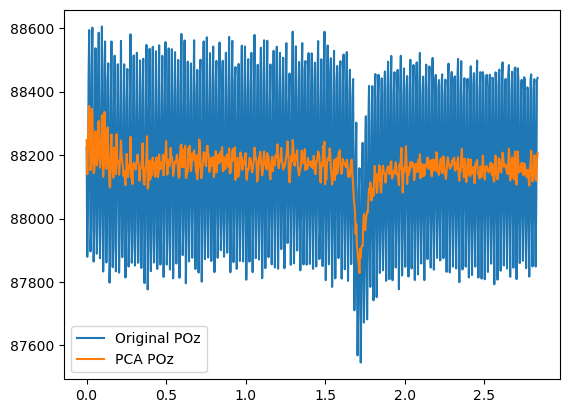

In [47]:
plt.plot(timeRange,df['POz'],label='Original POz')
plt.plot(timeRange,cleaned_df['POz'],label='PCA POz')
plt.legend()
plt.show()

In [48]:
Freq,Mag = computeFFT(df['POz'])
FreqF,MagF = computeFFT(cleaned_df['POz'])

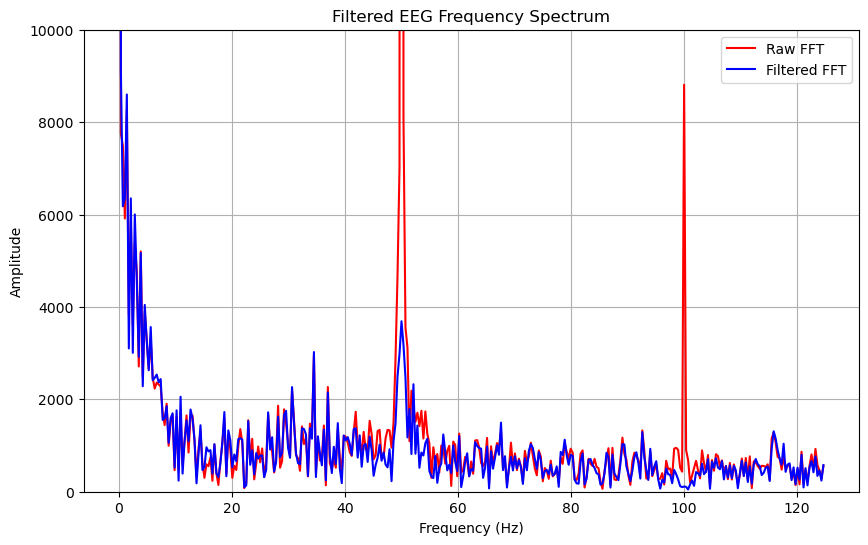

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(Freq, Mag, color='red',label='Raw FFT')
plt.plot(FreqF, MagF, color='blue',label='Filtered FFT')
plt.title('Filtered EEG Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.ylim(-1,10000)
plt.show()